In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from saxs_data_processing import io, manipulate, target_comparison, subtract
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

## User parameter setup

List of all background files to use. Data loading function will find associated data files in the same directory as backgrounds.

In [3]:
background_fps = ['/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_11_12_optimizationRound2/data/03619_B11-T2_Ethanol_background_1_000.dat']

In [4]:
previous_result_df = pd.read_csv('../2024_11_04_OptimizationRound1/amplitude_phase_results_11_11_24.csv')

Select q ranges. Right now this relies on manual q range selection to a certain extent. We subtract background and fit the spline on a larger q-range, then evaluate the spline on a subset of the larger q range to avoid spline edge effects.

In [5]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

Select target particle parameters. Target is spherical particles with radius r and polydispersity pdi

In [6]:
target_r_nm = 60
target_r_angs = target_r_nm*10
target_pdi = 0.08
sld_silica = 8.575
sld_etoh = 9.611

Set processing and optimization parameters for distance calculation

In [7]:
# SavGol denoise filter parameters
savgol_n = 15
savgol_order = 3
# minimum data length - data with less than ~100 data points is due to valid data selection step in subtraction and is likley too noisy to do anything with.
min_data_len = 100

# spline fit parameters
s = 0.05
k = 3

#scale parameters
n_avg = 100

# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10

## ######################## STOP: Don't touch anything below here \#############################


## Load data

In [8]:
sample_data, uuid2bkg = io.load_biocube_data_with_background(background_fps, 24)

## Calculate target scattering

In [9]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

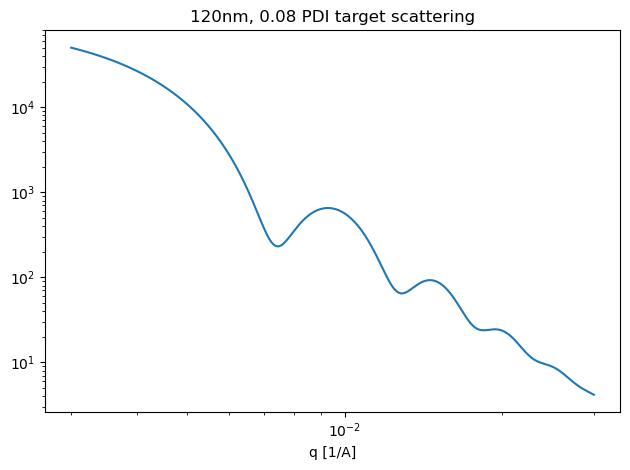

In [15]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')
ax.set_title('120nm, 0.08 PDI target scattering')
plt.tight_layout()
plt.savefig('target_profile_120nm.png', dpi = 300)

21d4f4ac-db02-41f9-b1ad-00c2e61fc894
lo q: 14, hi q: 904


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn(


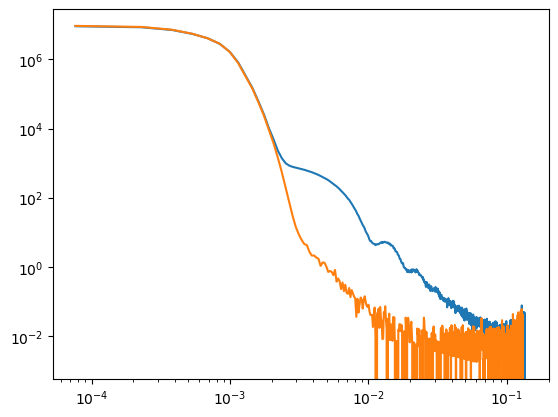

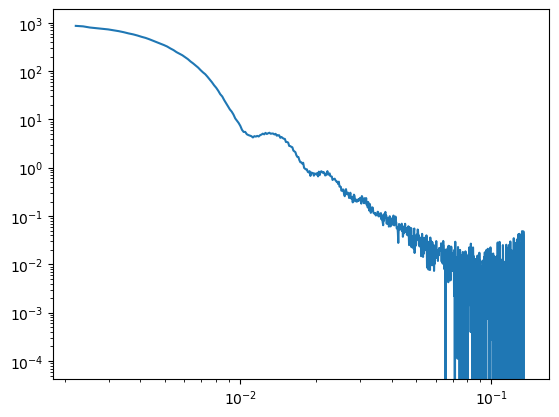

In [57]:
uuid_val = '21d4f4ac-db02-41f9-b1ad-00c2e61fc894'
entry = sample_data[uuid_val]

print(uuid_val)
bkg = uuid2bkg[uuid_val]

ratio_run = manipulate.ratio_running_average(entry[0]['I'], bkg[0]['I'])

subtracted = subtract.chop_subtract(entry[0], bkg[0], hiq_thresh=1)

fig, ax = plt.subplots()
ax.loglog(entry[0]['q'], entry[0]['I'])
ax.loglog(bkg[0]['q'], bkg[0]['I'])

fig, ax = plt.subplots()
if subtracted is not None:
    ax.loglog(subtracted['q'], subtracted['I'])
else:
    ax.text(1,1, 'failed')

## Run full processing pipeline

In [58]:
processing_dataset = {}
for uuid_val, data_val in sample_data.items():
    meas_entry = {}
    meas_entry['original_data'] = data_val[0]
    background = uuid2bkg[uuid_val]
    meas_entry['background'] = background[0]
    # 1. Subtract background and select q range
    subtracted = subtract.chop_subtract(data_val[0], background[0], hiq_thresh=1)
    
    if subtracted is None:
        # if subtract returned None, data has issues and we are done with this sample
        meas_entry['status'] = 'failed'
        meas_entry['failure_point'] = 'background_subtraction'
        processing_dataset[uuid_val] = meas_entry
        print(f'Sample {uuid_val} failed at background subtraction')
        continue
        
    else:
        # q range selection
        subtracted = subtracted[subtracted['q'] < q_max_subtract]
        subtracted = subtracted[~subtracted['I'].isna()]
        subtracted = subtracted[subtracted['I'] > 0] # drop negative values 
        # screen on dataset length
        if len(subtracted) < min_data_len:
            meas_entry['status'] = 'failed'
            meas_entry['failure_point'] = 'subtracted_data_length'
            processing_dataset[uuid_val] = meas_entry
            print(f'Sample {uuid_val} failed due to data length')
            continue
        else:
            meas_entry['subtracted_clipped'] = subtracted
            meas_entry['status'] = 'valid'
            processing_dataset[uuid_val] = meas_entry


    # 2. Convert everything into log10 space
    q_log = np.log10(subtracted['q'].to_numpy())
    I_log = np.log10(subtracted['I'].to_numpy())

    meas_entry['q_log'] = q_log
    meas_entry['I_log'] = I_log
    
    # 3. denoise filter on intensity
    
    I_savgol = manipulate.denoise_intensity(I_log, savgol_n = savgol_n, savgol_order = savgol_order)

    meas_entry['I_savgol'] = I_savgol

    # 4. Spline fit and interpolate
    I_spline = manipulate.fit_interpolate_spline(q_log, I_savgol, q_grid, s = s, k = k)
    
    meas_entry['I_spline'] = I_spline

    # 5. scale onto target
    I_scaled = manipulate.scale_intensity_highqavg(I_spline, target_I, n_avg = n_avg)

    meas_entry['I_scaled'] = I_scaled

    #6. Calculate AP distance

    amplitude, phase = target_comparison.ap_distance(q_grid, I_scaled, target_I, optim = optim, grid_dim = grid_dim)

    ap_sum = amplitude + phase

    meas_entry['amplitude_distance'] = amplitude
    meas_entry['phase_distance'] = phase
    meas_entry['ap_sum_distance'] = ap_sum

    processing_dataset[uuid_val] = meas_entry
    

lo q: 70, hi q: 904
lo q: 53, hi q: 904


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/manipulate.py:148: RuntimeWarning: divide by zero encountered in log10
  I_scaled = np.log10(scaled_meas)


lo q: 70, hi q: 463
Sample 3988b456-0f05-4af3-af65-7da9eab0ee6c failed due to data length
lo q: 14, hi q: 904
lo q: 18, hi q: 904
lo q: 34, hi q: 904
lo q: 20, hi q: 904
lo q: 70, hi q: 904
lo q: 22, hi q: 904
lo q: 69, hi q: 904
lo q: 24, hi q: 904
lo q: 34, hi q: 904
lo q: 70, hi q: 904


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/manipulate.py:139: RuntimeWarning: overflow encountered in power
  pow_meas = 10**I_measured
/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/manipulate.py:146: RuntimeWarning: overflow encountered in multiply
  scaled_meas = pow_meas * quotient


lo q: 70, hi q: 573
lo q: 21, hi q: 904
lo q: 70, hi q: 904
lo q: 27, hi q: 904
lo q: 17, hi q: 904
lo q: 70, hi q: 904
lo q: 69, hi q: 904


## Calculate RMSE for comparison

In [12]:
q_grid

array([-2.52287875, -2.52187875, -2.52087875, ..., -1.52487875,
       -1.52387875, -1.52287875])

In [15]:
len(processing_dataset)

20

### Sanity check subtraction

0799ec06-5d0f-4589-a10c-b9a98c310f5c
3f24b844-1e01-4b2d-976d-9083d8131fe3
3988b456-0f05-4af3-af65-7da9eab0ee6c
failed at  subtracted_data_length
21d4f4ac-db02-41f9-b1ad-00c2e61fc894
7371d32e-f23b-42a1-93d2-565008fc710f
13a21dba-b25c-4ec6-945b-e13b30d2d50f
1af462f0-d499-436c-bf10-135830a958c5
3af12ee2-596f-48b6-8c5b-565269a55562
9cabbf21-c7c6-4d8c-b88f-27e18a59fa8d
c1a8b4e0-1bd4-4ea2-9cb4-f3a5e09fb320
02bb1532-f5b4-4970-a885-68b4b420114e
5f681f1c-0c9a-4fe9-822f-9b8173449c11
37300e48-9860-4742-8c2b-0ca12c5d51d1
131f3c99-0c3f-430d-880c-effef7248f1f
9184744f-b57b-466e-ac26-2628b429fdda
d027691b-6a39-43f7-8527-56dd93433485
1e26acd9-0b68-4941-96c0-f56653643d27
d298bae0-5f86-4a29-b399-111644195748
4d0ecb5c-939e-4cf3-ad18-c4651703d936
29583b9e-3026-4b38-b781-e1b63ff2fa04


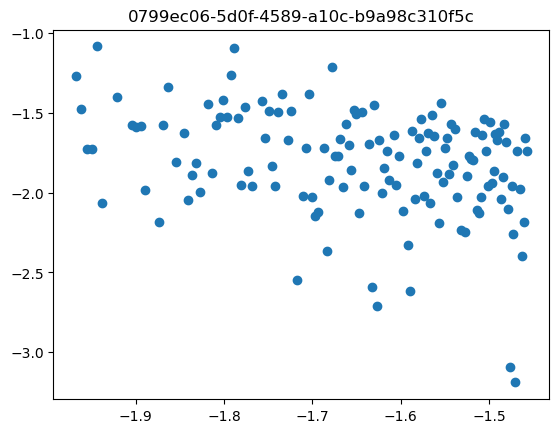

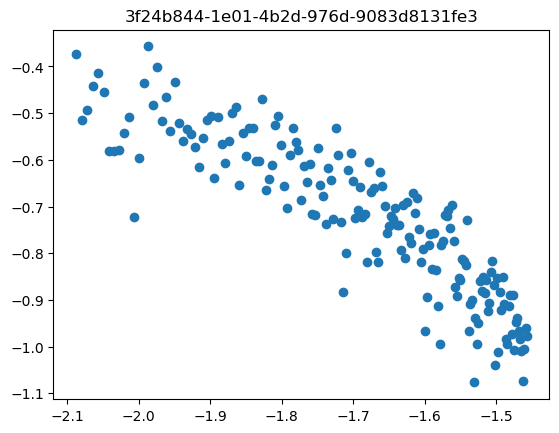

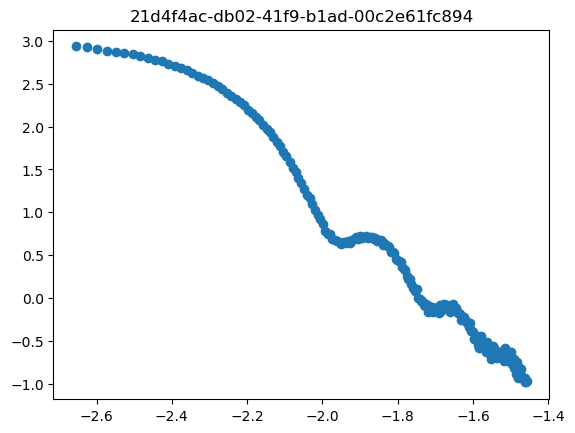

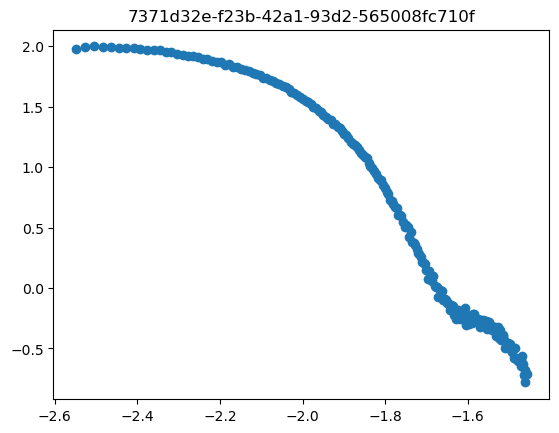

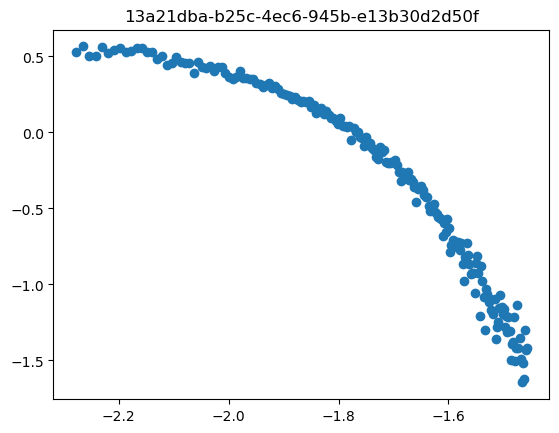

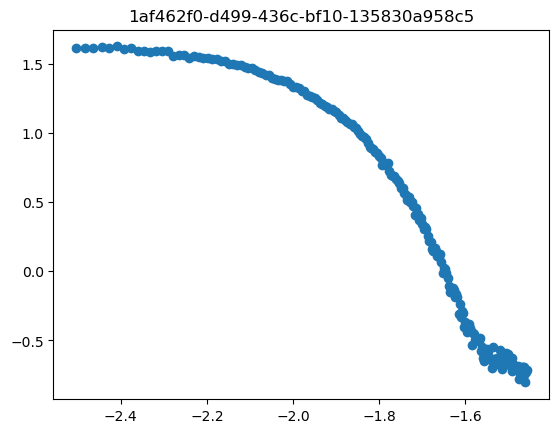

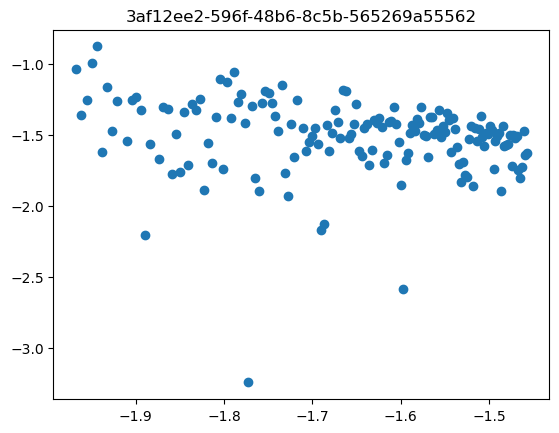

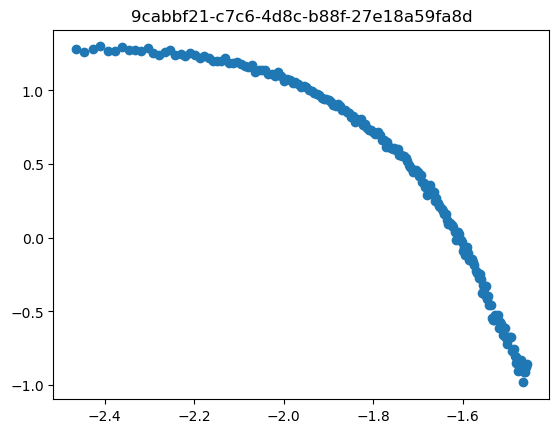

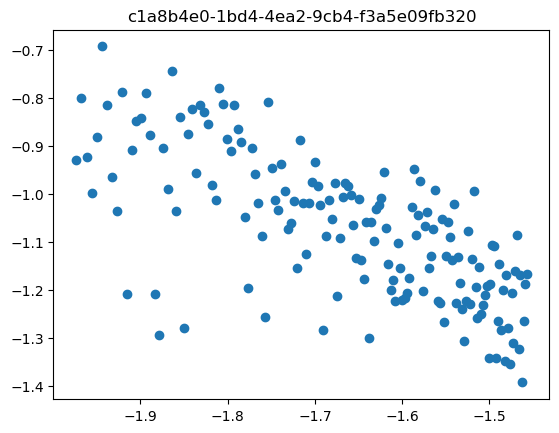

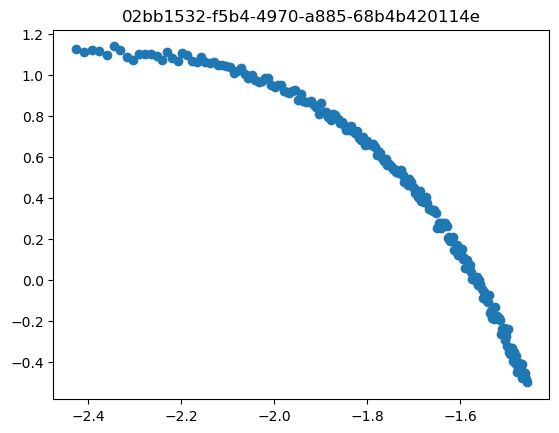

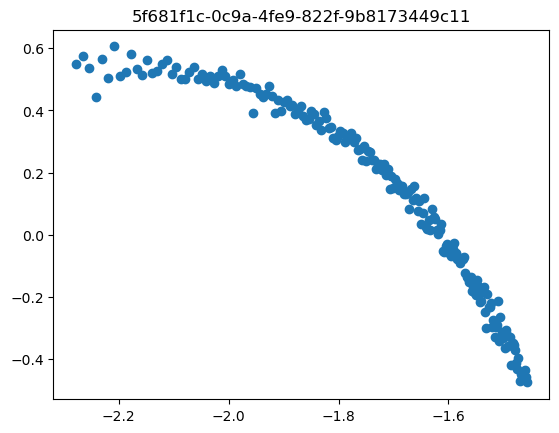

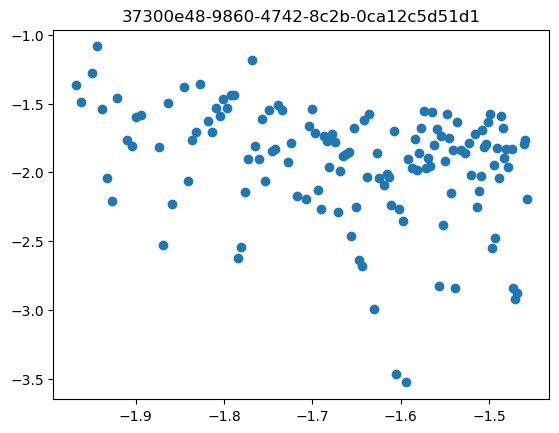

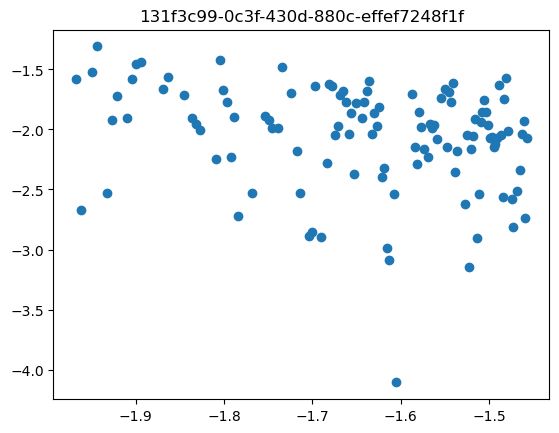

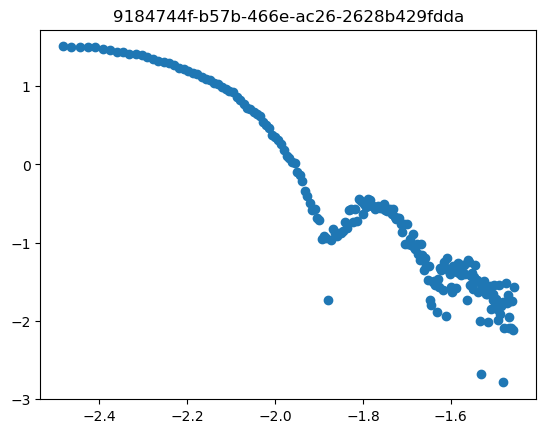

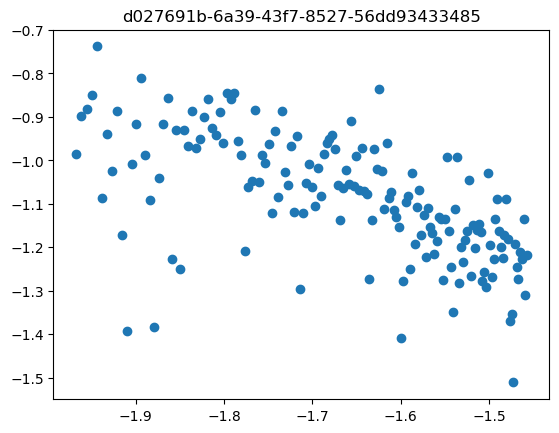

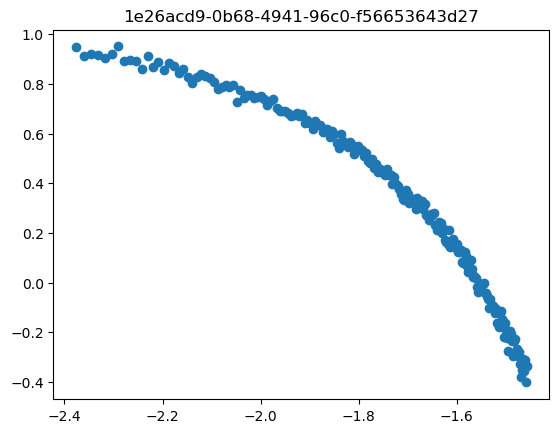

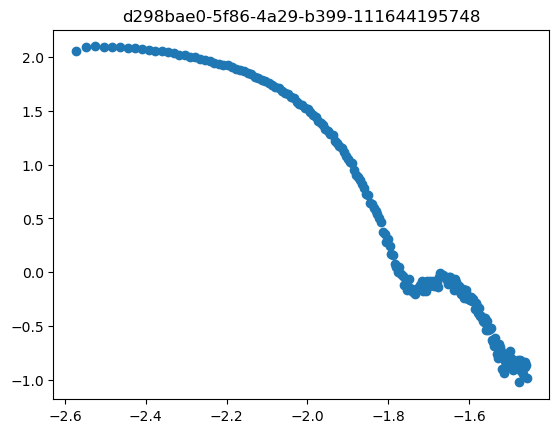

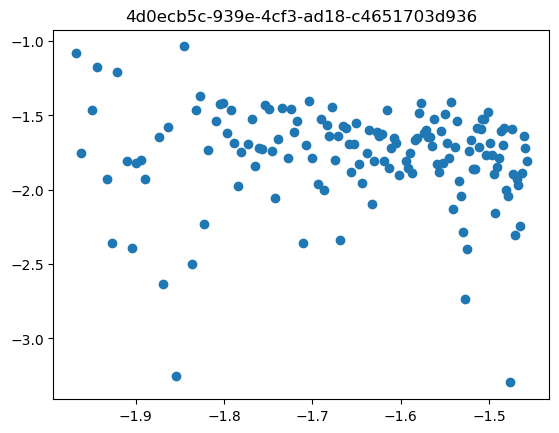

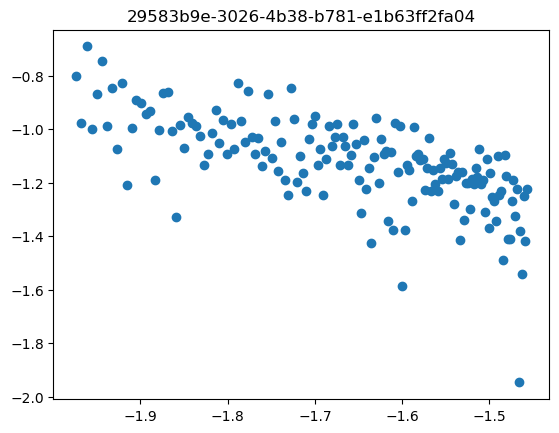

In [59]:
for uuid_val, entry in processing_dataset.items():
    print(uuid_val)
    try:
        status = entry['status']
        if status == 'failed':
            print('failed at ', entry['failure_point'])
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()
    
        I_subtracted = entry['I_log']
        q = entry['q_log']
    
        ax.scatter(q, I_subtracted)
        ax.set_title(uuid_val)

## Sanity check spline fit

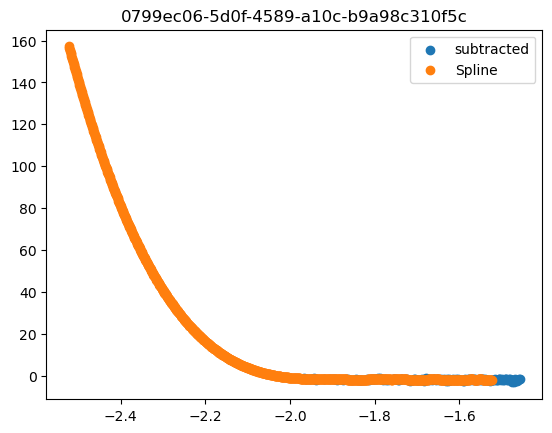

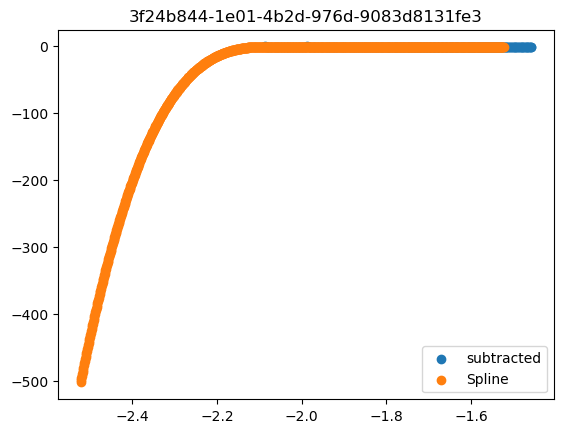

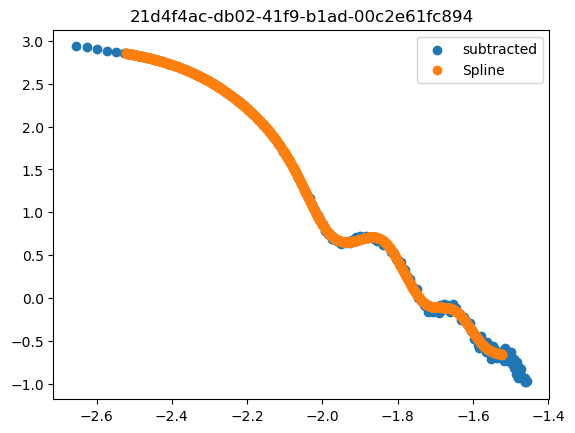

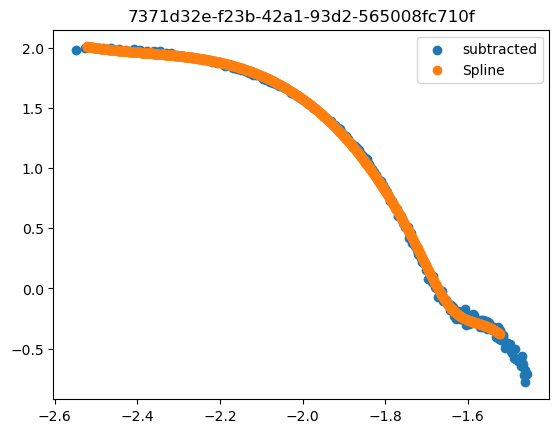

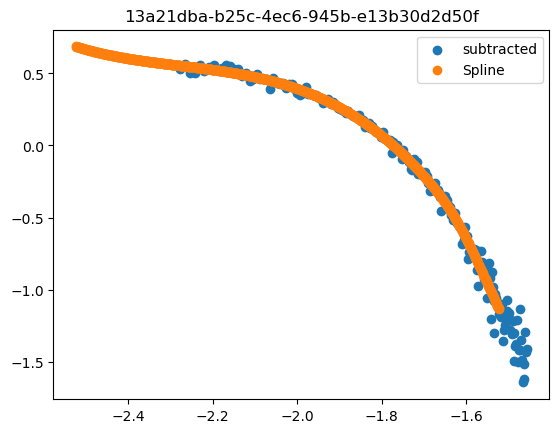

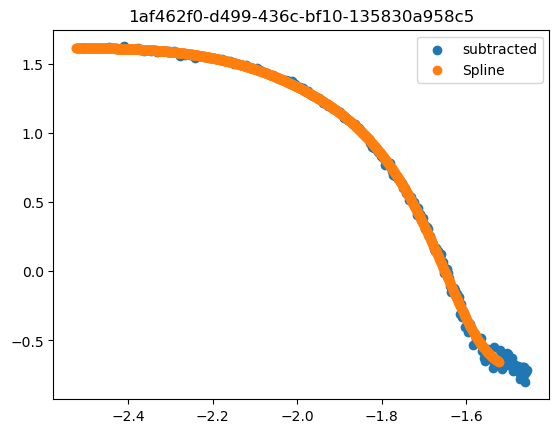

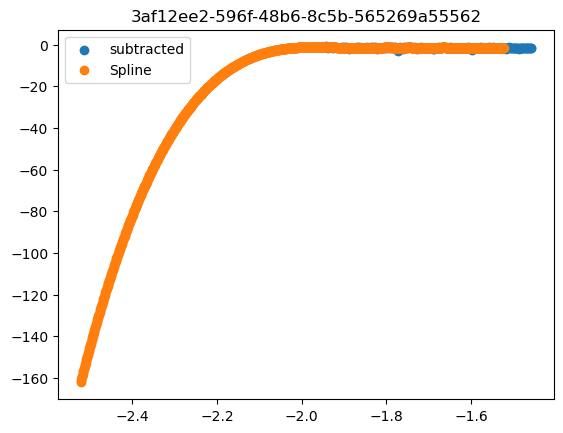

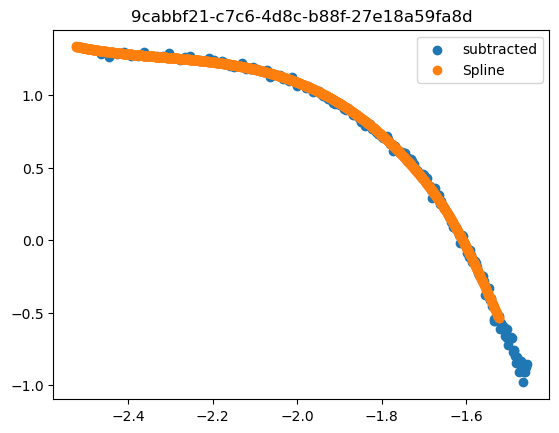

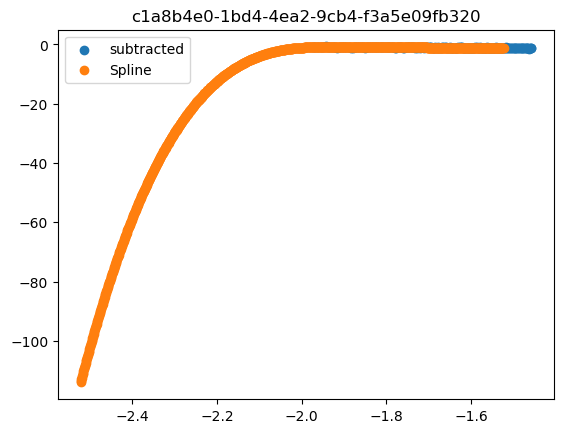

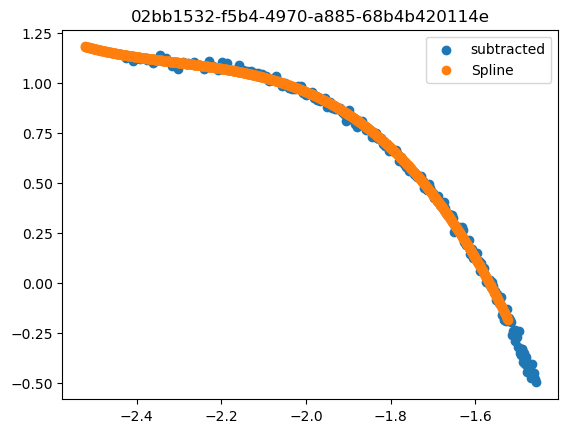

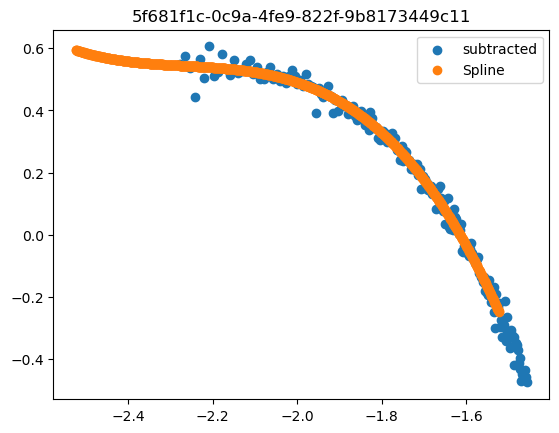

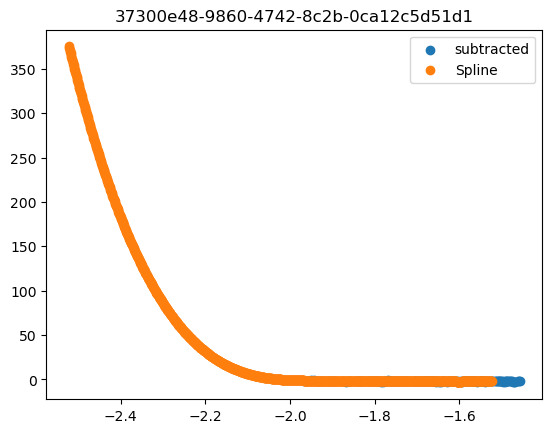

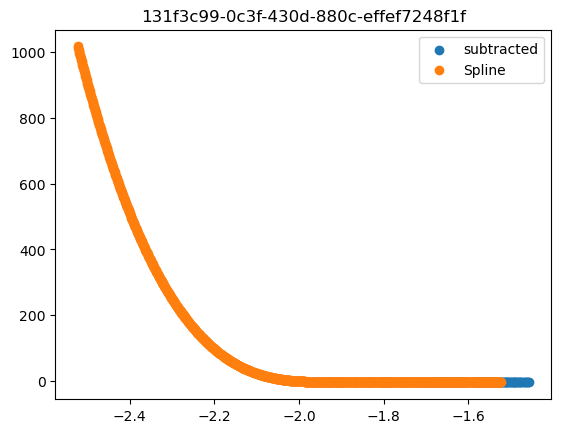

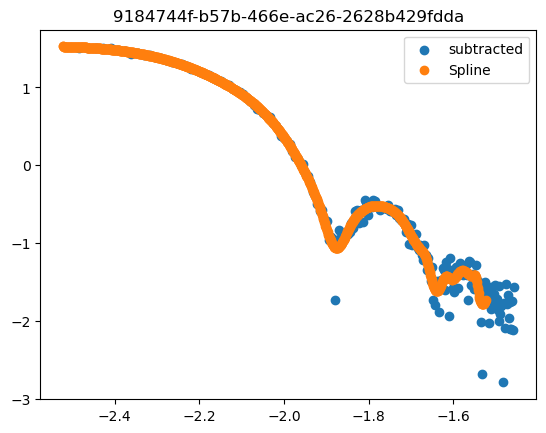

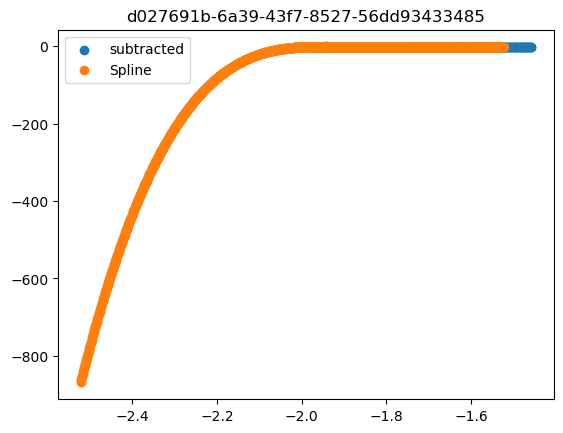

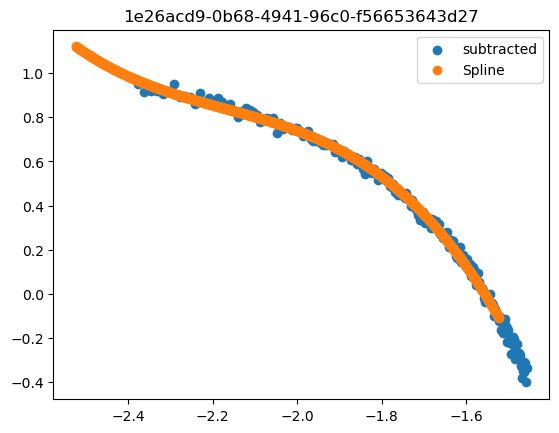

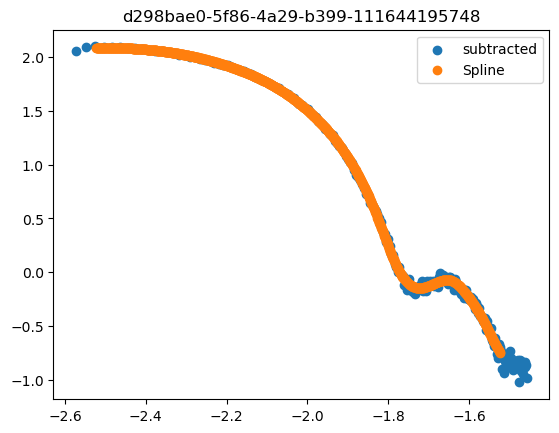

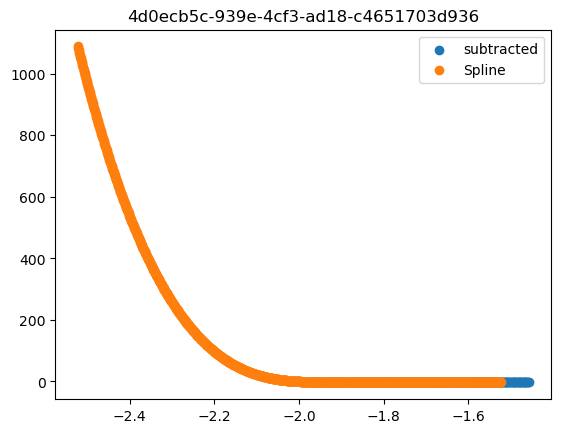

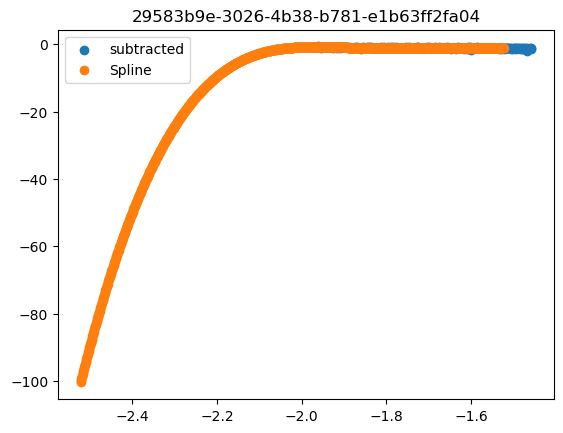

In [60]:
for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()
    
        I_subtracted = entry['I_log']
        q = entry['q_log']

        I_spline = entry['I_spline']
        
    
        ax.scatter(q, I_subtracted, label = 'subtracted')
        ax.scatter(q_grid, I_spline, label = 'Spline')
        ax.legend()
        ax.set_title(uuid_val)

## Sanity check scaling

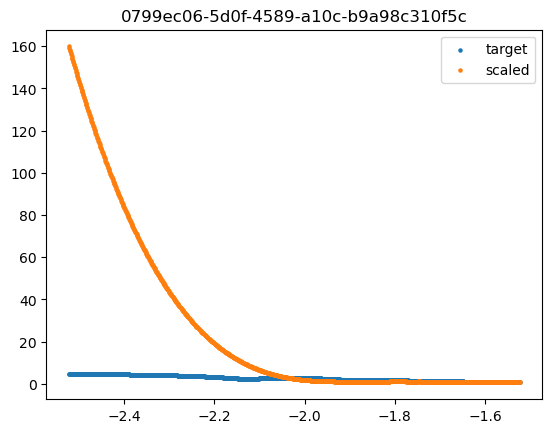

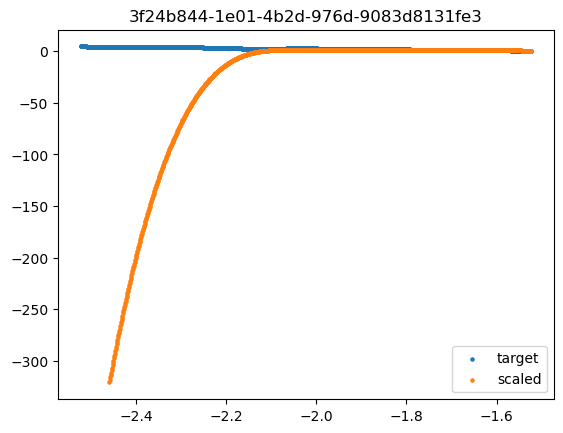

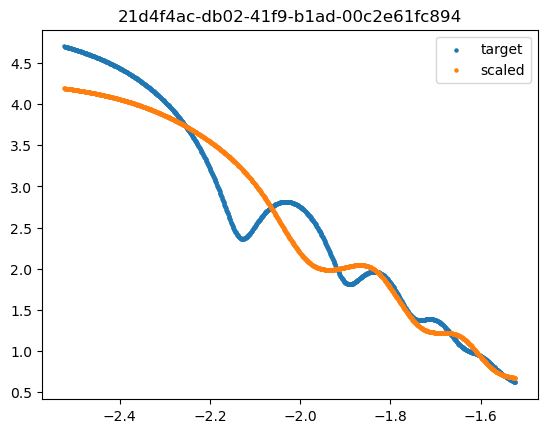

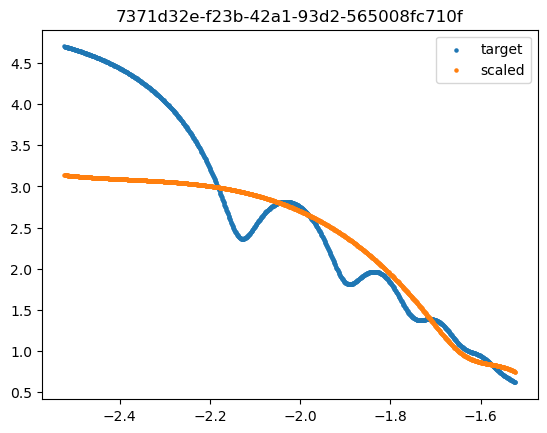

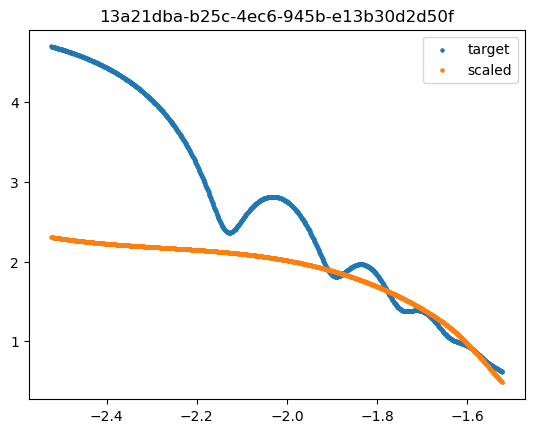

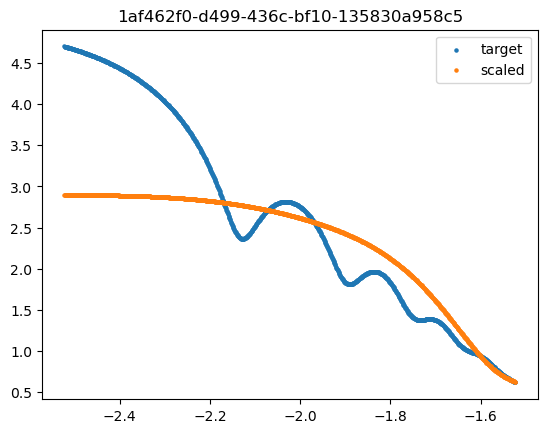

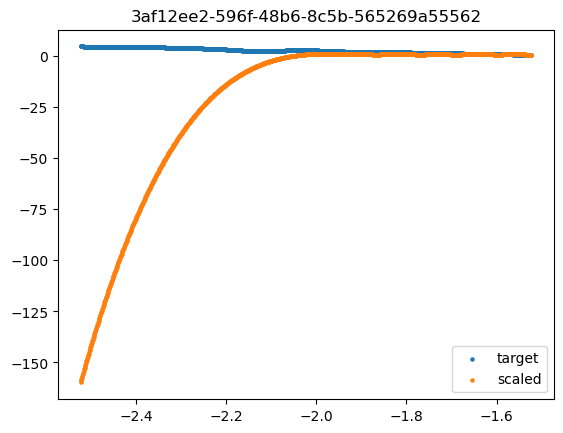

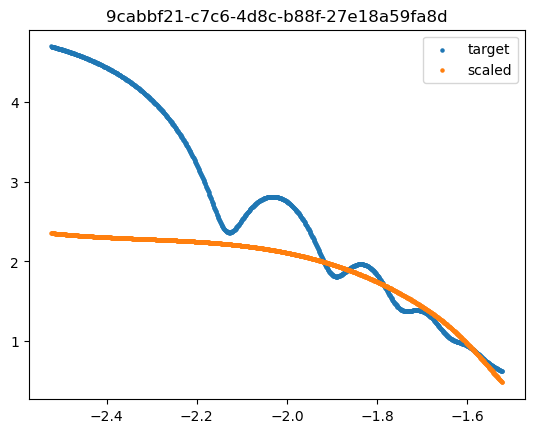

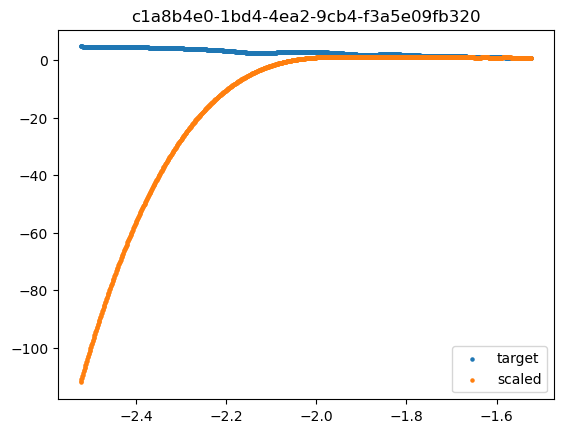

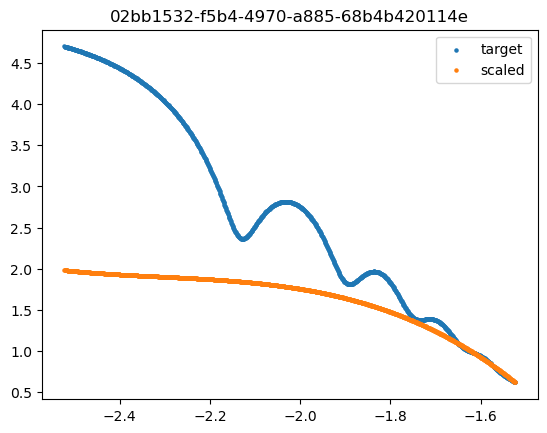

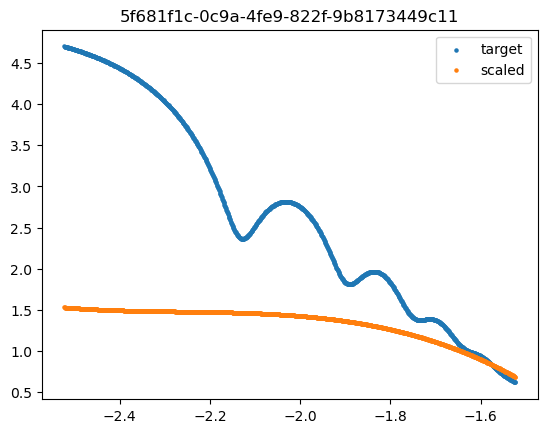

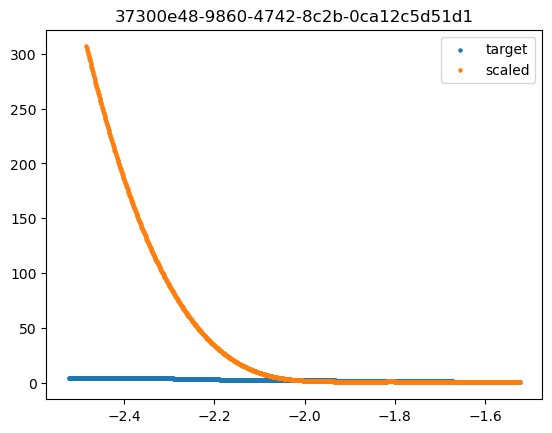

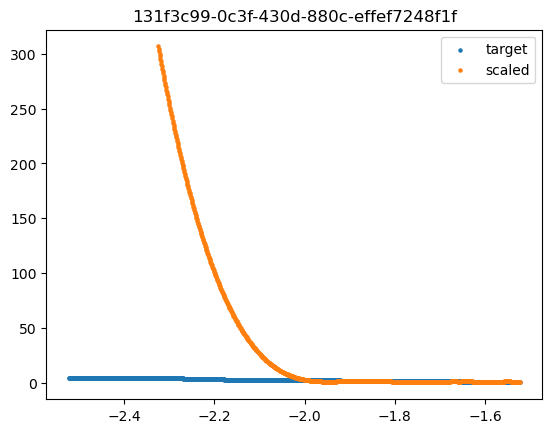

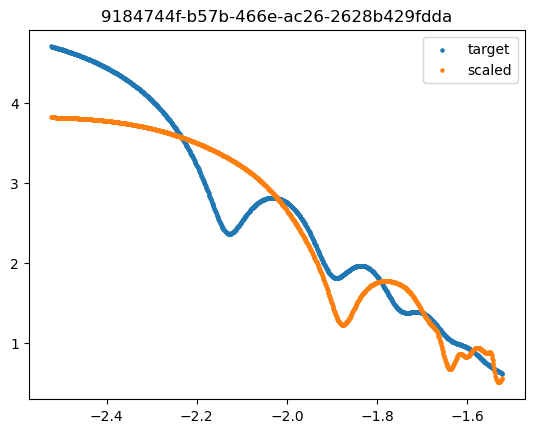

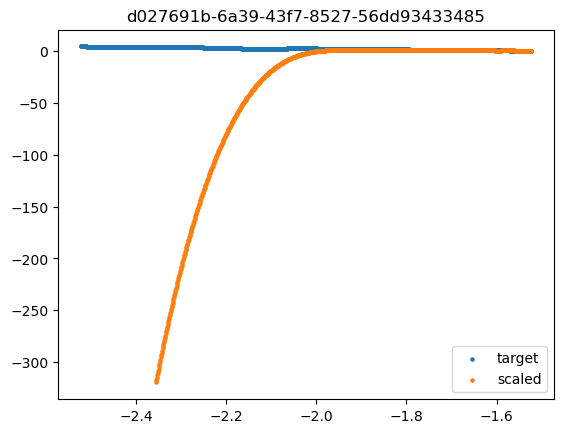

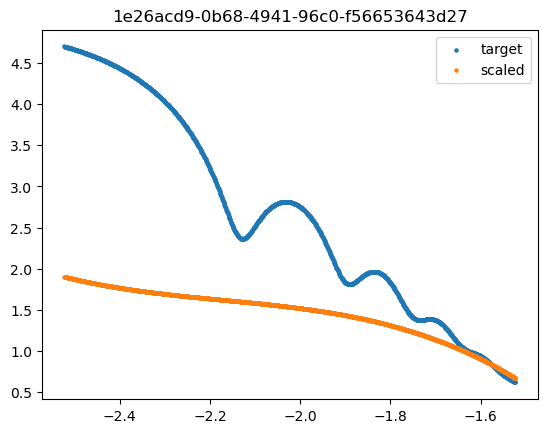

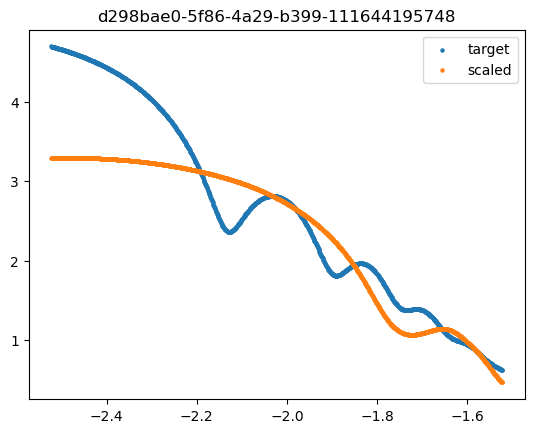

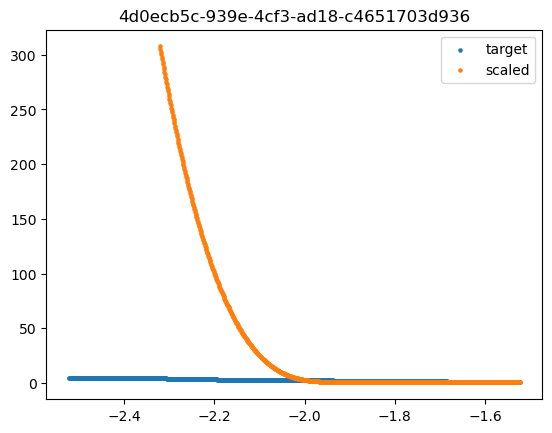

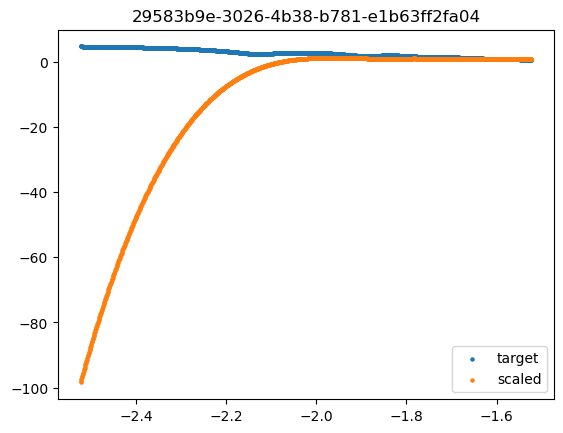

In [61]:
for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()


        I_scaled = entry['I_scaled']
        
    
        ax.scatter(q_grid, target_I, label = 'target', s = 5)
        ax.scatter(q_grid, I_scaled, label = 'scaled', s = 5)
        ax.legend()
        ax.set_title(uuid_val)

## Plot final ranked order of best samples

In [62]:
sum_ap = {}
for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            continue
        else:
            raise KeyError
            
    except KeyError:
        sum_ap[uuid_val] = entry['ap_sum_distance']


uuids = np.array(list(sum_ap.keys()))
rmses = list(sum_ap.values())
uuid_sorted_sum = uuids[np.argsort(rmses)]

In [63]:

with PdfPages('ranked_apdist_results.pdf') as pdf:
    for i, uuid_val in enumerate(uuid_sorted_sum):

        entry  = processing_dataset[uuid_val]
        I_scaled = entry['I_scaled']
        
        distance = sum_ap[uuid_val]
    
        fig, ax = plt.subplots()
        ax.scatter(q_grid, target_I)
        ax.scatter(q_grid, I_scaled)
        ax.set_title(uuid_val)
        ax.text(0.1, 0.05, f'Rank: {i}, sum distance: {distance}', transform = ax.transAxes)
        pdf.savefig()
        plt.close()

## Plot RMSE ranked for comparison

In [71]:
rmse_dist = {}
for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            continue
        else:
            raise KeyError
    except KeyError:
        rmse_dist[uuid_val] = entry['rmse_powerlaw_dist']


uuids = np.array(list(rmse_dist.keys()))
rmses = list(rmse_dist.values())
uuid_sorted_rmse = uuids[np.argsort(rmses)]

In [72]:

with PdfPages('ranked_rmse_dist_results.pdf') as pdf:
    for i, uuid_val in enumerate(uuid_sorted_rmse):

        entry  = processing_dataset[uuid_val]
        I_scaled = entry['I_scaled']
        
        distance = rmse_dist[uuid_val]
    
        fig, ax = plt.subplots()
        ax.scatter(q_grid, target_I)
        ax.scatter(q_grid, I_scaled)
        ax.set_title(uuid_val)
        ax.text(0.1, 0.05, f'Rank: {i}, sum distance: {distance}', transform = ax.transAxes)
        pdf.savefig()
        plt.close()

## Write results to disk

In [64]:
uuid_vals = []
amplitude = []
phase = []
sum_ap = []
statuses = []

for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            uuid_vals.append(uuid_val)
            amplitude.append(None)
            phase.append(None)
            sum_ap.append(None)
            statuses.append('failed')
            continue
        else:
            raise KeyError
    except KeyError:
        uuid_vals.append(uuid_val)
        amplitude.append(entry['amplitude_distance'])
        phase.append(entry['phase_distance'])
        sum_ap.append(entry['ap_sum_distance'])
        statuses.append('success')
    

In [65]:
results_df = pd.DataFrame({'uuid':uuid_vals, 'amplitude_distance':amplitude, 'phase_distance':phase, 'sum_ap_distance':sum_ap, 'processes_status':statuses})

In [68]:
new_results_df = pd.concat([previous_result_df, results_df])

In [70]:
new_results_df.to_csv('amplitude_phase_results_afterOptimRound2_11_13_24.csv')

In [71]:
new_results_df

,Unnamed: 0,uuid,amplitude_distance,phase_distance,sum_ap_distance,processes_status
0,0.0,770a433d-0480-4cee-bf12-ce066c24db55,1.079610,4.074514e-01,1.487061,success
1,1.0,fed3ab35-04e9-4916-8527-8627191a3bdc,0.474113,1.775399e-01,0.651653,success
2,2.0,4ab46dcc-3395-4e7b-bb87-52e805e12abb,0.979413,5.400224e-01,1.519435,success
3,3.0,23850c30-c572-41ad-abf0-7e1bd4fa7397,NaN,NaN,NaN,failed
4,4.0,96ef6012-d812-4975-8b77-8ed7e78669fb,1.003274,5.202165e-01,1.523491,success
...,...,...,...,...,...,...
15,NaN,d027691b-6a39-43f7-8527-56dd93433485,NaN,2.580957e-08,NaN,success
16,NaN,1e26acd9-0b68-4941-96c0-f56653643d27,1.428278,5.194059e-01,1.947684,success
17,NaN,d298bae0-5f86-4a29-b399-111644195748,1.054124,5.120969e-01,1.566220,success
18,NaN,4d0ecb5c-939e-4cf3-ad18-c4651703d936,NaN,2.580957e-08,NaN,success
